In [204]:
%matplotlib inline

In [195]:
from catboost import Pool, CatBoostRegressor, cv

In [196]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

In [197]:
from sklearn.preprocessing import QuantileTransformer

In [198]:
data_all = pd.read_csv('lab_dataset_isolated.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,13.008867,4.997579,6.588583,0.526244,0.203860,0.269896,24.545291,2.822392,0.978304,1.805997,...,1.640288,0.666432,1.253505,15.278301,0.700631,0.999954,1,1,1,10
1,6.609362,3.189992,5.576801,0.421152,0.211133,0.367715,15.238694,-0.296128,0.806050,2.021186,...,1.651874,0.741170,1.449528,15.278150,0.751461,0.999924,1,1,2,10
2,4.543573,2.450310,5.857017,0.348217,0.193641,0.458142,12.801766,0.110082,-0.123097,2.276599,...,1.654976,0.649358,1.179714,15.278049,0.650021,0.999934,1,1,3,10
3,9.122896,5.277992,7.450680,0.414250,0.247133,0.338618,21.968466,0.975603,1.584207,2.926163,...,1.640274,0.670234,1.247952,15.277748,0.640363,1.000000,1,1,4,10
4,12.466345,7.668964,7.305215,0.455908,0.279164,0.264928,27.811060,0.867278,2.583827,1.179988,...,1.621492,0.635067,1.139174,15.278251,0.710897,0.999888,1,1,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,8.720496,3.851477,9.021509,0.410116,0.176919,0.412965,21.800934,1.107516,-2.193685,0.777071,...,1.542705,0.385582,0.544647,15.586546,0.451471,0.999797,12,8,14,2
1572,6.408689,3.310907,9.966467,0.326135,0.169916,0.503949,19.780738,0.355814,-1.368689,2.422212,...,1.558130,0.443621,0.607946,15.586709,0.461571,0.999650,12,8,15,2
1573,3.515711,2.250204,10.708599,0.216626,0.135352,0.648022,16.726009,-1.599358,-0.663121,4.998161,...,1.548392,0.453187,0.541683,15.586424,0.449059,0.999922,12,8,16,2
1574,4.500857,2.437937,12.810566,0.228281,0.121847,0.649872,19.760628,0.172997,-0.698937,6.929964,...,1.565545,0.478419,0.722761,15.586668,0.458831,0.999912,12,8,17,2


In [199]:
X_test = data_all.loc[(data_all['Subj']  == 11)].reset_index(drop=True)
X_train = data_all.loc[(data_all['Subj'] != 11)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'labels', 'Subj'], axis=1)
X_test = X_test.drop(['film', 'labels', 'Subj'], axis=1)


qt_train = QuantileTransformer(output_distribution='normal',
                           copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

In [ ]:
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=['ch'])

In [201]:
y_pred = model.predict(X_test)

In [202]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

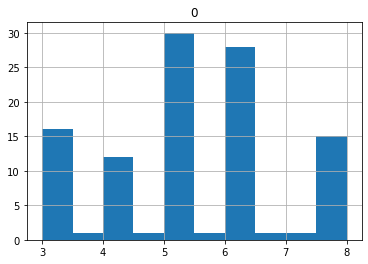

In [205]:
pd.DataFrame(preds).hist()

In [206]:
pd.DataFrame(preds).describe()

,0
count,106.000000
mean,5.305111
std,1.508163
min,3.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,8.000000


In [211]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(12)]
num_chans = [[0 for j in range(8)] for i in range(12)]
labels = [[0 for j in range(8)] for i in range(12)]
lbl = [[0 for j in range(8)] for i in range(12)]
channels = [[] for i in range(12)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [212]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 8.00 predicted: 6.38 
label : 3.00 predicted: 4.84 
label : 5.00 predicted: 3.27 
label : 8.00 predicted: 5.60 
label : 6.00 predicted: 6.50 
label : 4.00 predicted: 5.37 


In [213]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [214]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.20855214862568405
MAPE: 0.31453140165241744
MAE :  1.576590625053142


## Таблица со значениями метрик

In [215]:
from tqdm import tqdm_notebook

In [216]:
models = ['CatboostRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(1, 9)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    
    train_pool = Pool(X_train, y_train, cat_features=['ch'])
    test_pool = Pool(X_test, y_test, cat_features=['ch'])
    model = CatBoostRegressor()
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    preds = qt_test.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('CatboostRegressor', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('CatboostRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('CatboostRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    
    pred = [[0 for j in range(8)] for i in range(12)]
    num_chans = [[0 for j in range(8)] for i in range(12)]
    labels = [[0 for j in range(8)] for i in range(12)]
    lbl = [[0 for j in range(8)] for i in range(12)]
    channels = [[] for i in range(12)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test_inv[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(8):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('CatboostRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('CatboostRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('CatboostRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

In [158]:
result.to_excel('metrics.xlsx')

In [159]:
result.describe().to_excel('metrics_described.xlsx')

In [173]:
params = {'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.1, 'loss_function' : 'RMSE'}

In [190]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

## Таблицы со значениями shap для всех фильмов (1 на тест, остальные на обучение)

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(1, 9)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    
    
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)
    model = CatBoostRegressor()
    model.fit(train_pool)
    X_train_summary = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=35, show=False)
    plt.savefig('F{}.png'.format(film),  bbox_inches='tight')
    plt.clf()